In [ ]:
!unzip /content/drive/MyDrive/QUESTAO1/KITTI-Sequence.zip -d /content/drive/MyDrive/QUESTAO1/objetos

In [ ]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt


# array = np.load('ground_truth.npy')

# Carregar o arquivo .obj
for x in range(30):
  print (f'00000{x}')
  mesh = trimesh.load(f'/content/objetos/00000{x}/00000{x}_points.obj')

  # Verificar se é uma nuvem de pontos
  if isinstance(mesh, trimesh.points.PointCloud):
      print("Arquivo contém apenas pontos, sem faces!")

      # Obter os pontos da nuvem
      points = np.array(mesh.vertices)

      # Criar um gráfico 3D para visualizar a nuvem de pontos
      fig = plt.figure(figsize=(8, 8))
      ax = fig.add_subplot(111, projection="3d")

      # Plotar os pontos
      ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c="b")

      plt.title("Nuvem de Pontos do Arquivo .OBJ")
      plt.show()
  else:
      print("O arquivo contém uma malha e pode ser renderizado normalmente.")
      mesh.show()



In [11]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [12]:
# Caminho da pasta onde estão os objetos
base_path = "/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence"

# Listar todas as subpastas (os índices de 6 dígitos)
scan_folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

# Construir os caminhos completos dos arquivos .obj
scan_files = [os.path.join(base_path, folder, f"{folder}_points.obj") for folder in scan_folders]

# Exibir os primeiros caminhos para verificar
print("Arquivos encontrados:")
for path in scan_files[:5]:  # Mostra os primeiros 5 arquivos encontrados
    print(path)


Arquivos encontrados:
/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence/000000/000000_points.obj
/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence/000001/000001_points.obj
/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence/000002/000002_points.obj
/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence/000003/000003_points.obj
/scratch/caio.grossi/dtlabs/Q1/objetos/KITTI-Sequence/000004/000004_points.obj


In [13]:
import re
import numpy as np

def load_obj(filepath):
    """Carrega um arquivo .obj e extrai os pontos 3D"""
    points = []
    if not os.path.exists(filepath):
        print(f"Arquivo não encontrado: {filepath}")
        return np.array(points)  # Retorna array vazio se o arquivo não existir

    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Apenas linhas de vértices
                parts = re.split(r'\s+', line.strip())
                points.append([float(parts[1]), float(parts[2]), float(parts[3])])
    return np.array(points)

# Carregar todas as point clouds corretamente
point_clouds = [load_obj(f) for f in scan_files]

# Verificar se os pontos foram carregados corretamente
print(f"Total de scans carregados: {len(point_clouds)}")
print(f"Formato do primeiro scan: {point_clouds[0].shape if len(point_clouds) > 0 else 'Nenhum ponto carregado'}")


Total de scans carregados: 30
Formato do primeiro scan: (62553, 3)


In [9]:
# Testar a leitura de um scan específico
test_scan_idx = 0  # Escolha um índice qualquer entre 0 e 29
test_scan = point_clouds[test_scan_idx]

print(f"Scan {test_scan_idx} - Primeiro 5 pontos:")
print(test_scan[:10])  # Mostra os primeiros 5 pontos carregados
print(f"Total de pontos carregados: {test_scan.shape[0]}")


Scan 0 - Primeiro 5 pontos:
[[-9.110238 18.638599  0.909355]
 [-9.151207 18.5732    0.908344]
 [-9.206173 18.536804  0.908331]
 [-9.278134 18.536415  0.909315]
 [-9.080147 17.786371  0.883326]
 [-9.115118 17.716974  0.882315]
 [-9.168084 17.682577  0.882302]
 [-9.246043 17.697189  0.883286]
 [-9.578927 18.192827  0.903238]
 [-9.640901 18.24164   0.906227]]
Total de pontos carregados: 62553


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

def nearest_neighbor_gpu(src, dst):
    """Calcula a correspondência de pontos mais próximos usando GPU"""
    src = torch.tensor(src, device=device, dtype=torch.float32)
    dst = torch.tensor(dst, device=device, dtype=torch.float32)

    # Calcular a distância euclidiana entre cada ponto de src e todos os pontos de dst
    dists = torch.cdist(src, dst)  # Calcula todas as distâncias de forma eficiente na GPU
    indices = torch.argmin(dists, dim=1)  # Obtém os índices dos pontos mais próximos

    return indices.cpu().numpy()  # Retorna para a CPU para compatibilidade

def best_fit_transform_gpu(A, B):
    """Calcula a melhor transformação rígida entre os pontos A e B na GPU"""
    A = torch.tensor(A, device=device, dtype=torch.float32)
    B = torch.tensor(B, device=device, dtype=torch.float32)

    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, _, Vt = torch.linalg.svd(H)

    R = Vt.T @ U.T
    if torch.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A

    return R.cpu().numpy(), t.cpu().numpy()

def icp_gpu(A, B, max_iterations=50, tolerance=1e-6):
    """ICP acelerado na GPU"""
    prev_error = float('inf')

    for i in range(max_iterations):
        indices = nearest_neighbor_gpu(A, B)
        matched_B = B[indices]

        R, t = best_fit_transform_gpu(A, matched_B)
        A = (R @ A.T).T + t  # Aplica a transformação na nuvem de pontos

        mean_error = np.mean(np.linalg.norm(A - matched_B, axis=1))
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R, t, A

Usando dispositivo: cuda


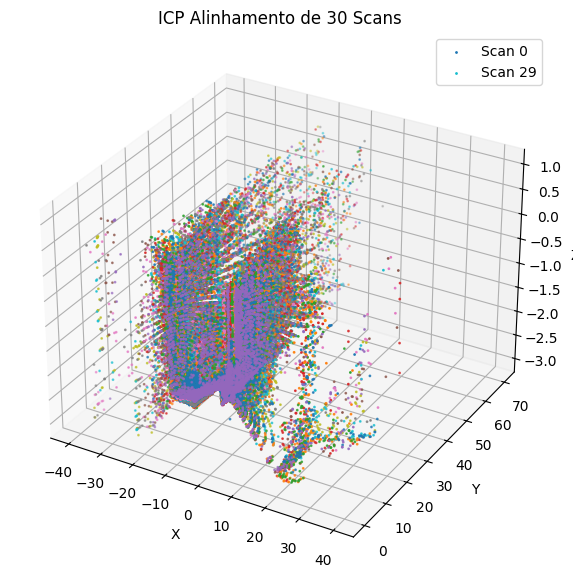

In [15]:
def plot_all_point_clouds_gpu(point_clouds, transformations, title="ICP Alinhamento de 30 Scans"):
    """Plota todas as 30 nuvens de pontos transformadas sobrepostas em um único gráfico"""
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i, (pc, T) in enumerate(zip(point_clouds, transformations)):
        pc_torch = torch.tensor(pc, device=device, dtype=torch.float32)

        # Aplicar transformação
        # Converter a matriz de transformação para um tensor no mesmo dispositivo
        T_torch = torch.tensor(T, device=device, dtype=torch.float32)

        # Aplicar transformação usando tensores do PyTorch
        transformed_pc = (T_torch[:3, :3] @ pc_torch.T).T + T_torch[:3, 3]

        # Converter o resultado de volta para numpy para plotagem
        transformed_pc = transformed_pc.cpu().numpy()

        ax.scatter(transformed_pc[:, 0], transformed_pc[:, 1], transformed_pc[:, 2], s=1, label=f"Scan {i}" if i in [0, 29] else None)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Inicializa as transformações com identidade
trajectory = [np.eye(4)]
current_pose = np.eye(4)

transformations = [current_pose]


def downsample_point_cloud(point_cloud, num_points=5000):
    """Reduz a quantidade de pontos da nuvem usando amostragem aleatória"""
    if point_cloud.shape[0] > num_points:
        indices = np.random.choice(point_cloud.shape[0], num_points, replace=False)
        return point_cloud[indices]
    return point_cloud

# Aplicar a redução em todas as point clouds antes do ICP
point_clouds = [downsample_point_cloud(pc, num_points=5000) for pc in point_clouds]

# Converter nuvens de pontos para GPU
point_clouds_gpu = [torch.tensor(pc, device=device, dtype=torch.float32) for pc in point_clouds]

# Aplicar ICP para cada scan na GPU
for scan_idx in range(1, len(point_clouds)):
    original_scan = point_clouds_gpu[scan_idx].cpu().numpy()
    reference_scan = point_clouds_gpu[scan_idx - 1].cpu().numpy()

    R, t, _ = icp_gpu(original_scan, reference_scan)

    transformation = np.eye(4)
    transformation[:3, :3] = R
    transformation[:3, 3] = t

    current_pose = current_pose @ transformation
    transformations.append(current_pose)

# Plotar os resultados
plot_all_point_clouds_gpu(point_clouds, transformations)


In [16]:
print("Min valores do primeiro scan:", np.min(point_clouds[0], axis=0))
print("Max valores do primeiro scan:", np.max(point_clouds[0], axis=0))


Min valores do primeiro scan: [-2.0923719e+01  4.8090000e-03 -2.2573780e+00]
Max valores do primeiro scan: [14.907434 67.299232  0.987307]


In [ ]:
for i, pose in enumerate(trajectory[:5]):  # Mostra as 5 primeiras poses
    print(f"Pose {i}:")
    print(pose)


In [18]:
# Carregar a ground-truth para comparação
ground_truth = np.load("/scratch/caio.grossi/dtlabs/Q1/ground_truth.npy")

# Inicializa a trajetória com a posição inicial (origem)
trajectory = [np.eye(4)]

# Itera pelos scans aplicando ICP
current_pose = np.eye(4)
for i in range(1, len(point_clouds)):
    R, t, aligned_pc = icp_gpu(point_clouds[i], point_clouds[i-1])

    # Atualiza a matriz de transformação
    transformation = np.eye(4)
    transformation[:3, :3] = R
    transformation[:3, 3] = t
    current_pose = current_pose @ transformation  # Acumulando transformações

    trajectory.append(current_pose)

# Converte a trajetória estimada para um array
trajectory = np.array(trajectory)




In [ ]:
print(trajectory.shape)
for i in range(30):
  print(trajectory[0])
print(ground_truth.shape)

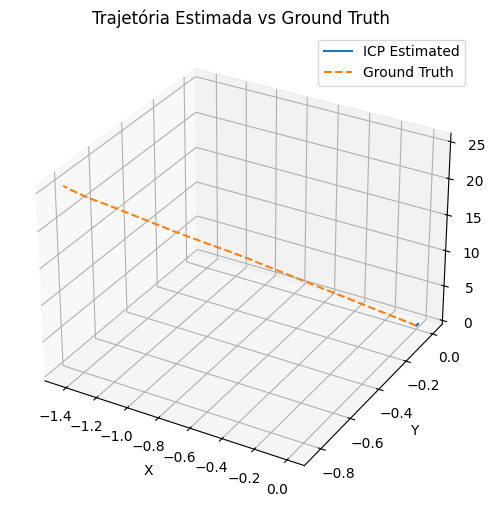

In [20]:
# Extraindo coordenadas (x, y, z) da trajetória estimada
estimated_positions = np.array([pose[:3, 3] for pose in trajectory])
ground_truth_positions = np.array([pose[:3, 3] for pose in ground_truth])

# Plotando
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(estimated_positions[:, 0], estimated_positions[:, 1], estimated_positions[:, 2], label="ICP Estimated")
ax.plot(ground_truth_positions[:, 0], ground_truth_positions[:, 1], ground_truth_positions[:, 2], label="Ground Truth", linestyle="dashed")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title("Trajetória Estimada vs Ground Truth")
plt.show()
